# Визуализация экспериментов

In [1]:
import glob
import json
import shutil
import sys

print(sys.version_info)
import os

os.environ["WANDB_CONSOLE"] = "off"
import uuid

import matplotlib.pyplot as plt
import pandas as pd
import wandb
from tqdm.auto import tqdm
import numpy as np

sys.version_info(major=3, minor=10, micro=8, releaselevel='final', serial=0)


In [2]:
api = wandb.Api()
root = "/home/asciishell/s3/jupyter.asciishell.ru"
path_config = f"{root}/logs/config/{{}}.json"
path_metrics = f"{root}/logs/metrics/{{}}.json"

In [3]:
runs_ = api.runs("mlao/chingyaoc-dcl")
runs = [x for x in runs_ if "protected" in x.tags]
len(runs)

40

In [4]:
runs = {x.config["uuid"]: x for x in runs}

In [5]:
exp_df = []
for uuid_ in runs:
    out = path_config.format(uuid_)
    if not os.path.exists(out):
        continue
    with open(out, "rb") as f:
        js = json.load(f)
        exp_df.append(js)

In [6]:
exp_df = pd.DataFrame(exp_df)

In [7]:
exp_df.drop(index=exp_df[exp_df["loss"] == "DebiasedPos"].index, inplace=True)
exp_df.replace({"DebiasedPosV2": "DebiasedPos"}, inplace=True)

In [8]:
exp_df.head(3)

,k,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,m_agg_mode,noise_frac,feature_dim,temperature
0,200,Contrastive,35116b37-823b-4a1b-b638-0077a8926445,resnet50,200,CIFAR10,False,2,0.1,64,loss_combination,0.0,128,0.5
1,200,DebiasedNeg,41b0aaf1-9456-41dd-b72f-8cfd4ba05a4d,resnet50,200,CIFAR10,False,2,0.1,64,loss_combination,0.0,128,0.5
2,200,DebiasedPos,191f92b9-931a-4f34-b122-6792c5744a65,resnet50,200,CIFAR10,False,2,0.1,64,loss_combination,0.0,128,0.5


In [9]:
def get_metrics(uuid):
    out = path_metrics.format(uuid)
    if not os.path.exists(out):
        return {}
    with open(out, "rb") as f:
        js = json.load(f)
    return pd.DataFrame(js)

In [10]:
colors_map = {"DebiasedPos": "indianred", "DebiasedNeg": "teal", "Contrastive": "peru"}

In [11]:
base_dict = {
    "model": "resnet50",
    "dataset": "CIFAR10",
    "drop_fn": False,
    "num_pos": 1,
    "tau_plus": 0.1,
    "batch_size": 64,
    "m_agg_mode": "loss_combination",
    "noise_frac": 0,
}
x = exp_df.copy()
for k, v in base_dict.items():
    x = x[x[k] == v].copy()
# base_df = x.drop(columns=list(base_dict.keys())).copy()
base_df = x.sort_values("loss").copy()
base_df

,k,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,m_agg_mode,noise_frac,feature_dim,temperature
23,200,Contrastive,857628f3-a7c7-4b4c-84dc-ef0315287d11,resnet50,200,CIFAR10,False,1,0.1,64,loss_combination,0.0,128,0.5
22,200,DebiasedNeg,976bd88c-44a6-42a1-8d61-38e37103d753,resnet50,200,CIFAR10,False,1,0.1,64,loss_combination,0.0,128,0.5
13,200,DebiasedPos,f92ba8f8-25d4-4ae1-b0ab-799a36ec7bed,resnet50,200,CIFAR10,False,1,0.1,64,loss_combination,0.0,128,0.5


## Эксперимент: base VS Drop FN = True
Сравниваем все лоссы. Хотим убедиться, что (1) исключение ошибки 1го рода (FN) улучшает качество моделей и (2) для Drop FN = True Debiased Pos лучше Contrastive и Debiased Neg? 

In [12]:
new_dict = base_dict.copy()
new_dict["drop_fn"] = True

x = exp_df.copy()
for k, v in new_dict.items():
    x = x[x[k] == v].copy()
new_df = x.sort_values("loss").copy()
new_df

,k,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,m_agg_mode,noise_frac,feature_dim,temperature
19,200,Contrastive,7bd9f783-0f8f-446a-aa08-8e011d08eef3,resnet50,200,CIFAR10,True,1,0.1,64,loss_combination,0.0,128,0.5
16,200,DebiasedNeg,d7ca6f2d-627a-4f88-9800-cc36654d3e21,resnet50,200,CIFAR10,True,1,0.1,64,loss_combination,0.0,128,0.5
12,200,DebiasedPos,95906880-716b-4c72-8c79-022baa101109,resnet50,200,CIFAR10,True,1,0.1,64,loss_combination,0.0,128,0.5


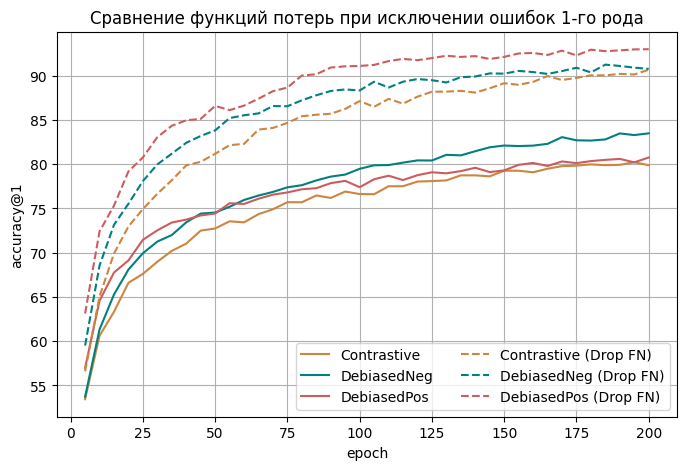

In [13]:
plt.figure(figsize=(8, 5))
for i, row in base_df.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"], color=colors_map[row["loss"]])

for i, row in new_df.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(
        m["epoch"], m["loss/acc1"], label=row["loss"] + " (Drop FN)", color=colors_map[row["loss"]], linestyle="--"
    )

plt.legend(ncol=2)
plt.xlabel("epoch")
plt.ylabel("accuracy@1")
plt.title("Сравнение функций потерь при исключении ошибок 1-го рода")
plt.grid()
plt.show()

- Ранжирование лоссов меняется. Предлагаемый лосс работает лучше остальных в случае исключения ошибок 1го рода (ложно отрицательные). 
- Между contrastive и debiasedNeg при исключении ошибок 1го рода различия практически нет на последних эпохах. 
- Аналогично нет разницы между contrastive и debiasedPos в исходном (базовом) эксперименте

Про базовый график:
- на ранних эпохах debiasedPos показывает себя лучше. Его можно использовать для инициализации, прогрева на первых эпохах

## Эксперимент: base VS Nose=True or/and Drop FN = True
Сравниваем все лоссы. Ожидаем, что (исключение ошибки 1го рода (FN) и/или) добавление ошибки 2го рода (FP), т.е. ухудшение датасета, может быть митигированно Debiased Pos лоссом

### base VS Nose=True

In [14]:
new_dict = base_dict.copy()
new_dict["noise_frac"] = 0.1

x = exp_df.copy()
for k, v in new_dict.items():
    x = x[x[k] == v].copy()
new_df_1 = x.sort_values("loss").copy()
new_df_1

,k,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,m_agg_mode,noise_frac,feature_dim,temperature
28,200,Contrastive,d89b0b43-a8f6-4f87-9f89-c00178830809,resnet50,200,CIFAR10,False,1,0.1,64,loss_combination,0.1,128,0.5
27,200,DebiasedNeg,95468ad7-47a7-437f-a48d-8cb763ce7b8d,resnet50,200,CIFAR10,False,1,0.1,64,loss_combination,0.1,128,0.5
10,200,DebiasedPos,f160039c-5934-44fa-bdcf-f5c7b27b6cf2,resnet50,200,CIFAR10,False,1,0.1,64,loss_combination,0.1,128,0.5


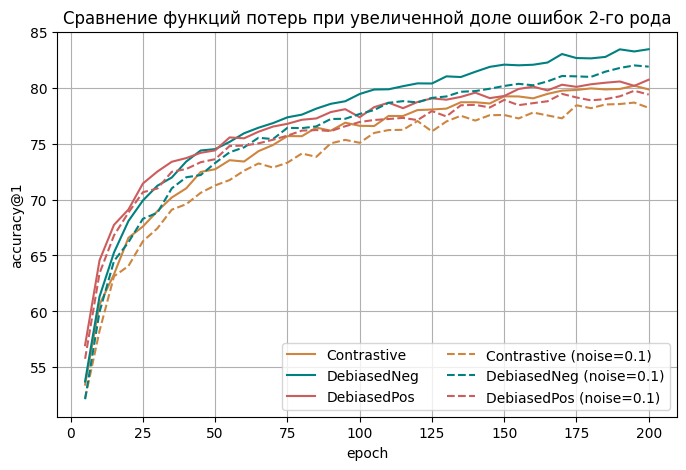

In [15]:
plt.figure(figsize=(8, 5))
for i, row in base_df.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"], color=colors_map[row["loss"]])

for i, row in new_df_1.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(
        m["epoch"], m["loss/acc1"], label=row["loss"] + " (noise=0.1)", color=colors_map[row["loss"]], linestyle="--"
    )

plt.legend(ncol=2)
plt.xlabel("epoch")
plt.ylabel("accuracy@1")
plt.title("Сравнение функций потерь при увеличенной доле ошибок 2-го рода")
plt.grid()
plt.show()

- Зашумление датасета (увеличение доли ошибок 2го рода - ложно положительных) ухудшает качество обучения 
- Для debiasedPos падение качества меньше (на всем периоде обучения)

In [16]:
new_dict = base_dict.copy()
new_dict["noise_frac"] = 0.3

x = exp_df.copy()
for k, v in new_dict.items():
    x = x[x[k] == v].copy()
new_df_3 = x.sort_values("loss").copy()
new_df_3

,k,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,m_agg_mode,noise_frac,feature_dim,temperature
3,200,Contrastive,25a94d26-8eef-49c0-9a7d-3c5f3399ea27,resnet50,200,CIFAR10,False,1,0.1,64,loss_combination,0.3,128,0.5
5,200,DebiasedNeg,c3999b91-1cd6-4f65-a956-42116231ceaf,resnet50,200,CIFAR10,False,1,0.1,64,loss_combination,0.3,128,0.5
4,200,DebiasedPos,1ca9c179-970d-42bf-a184-e578f1a9aa9c,resnet50,200,CIFAR10,False,1,0.1,64,loss_combination,0.3,128,0.5


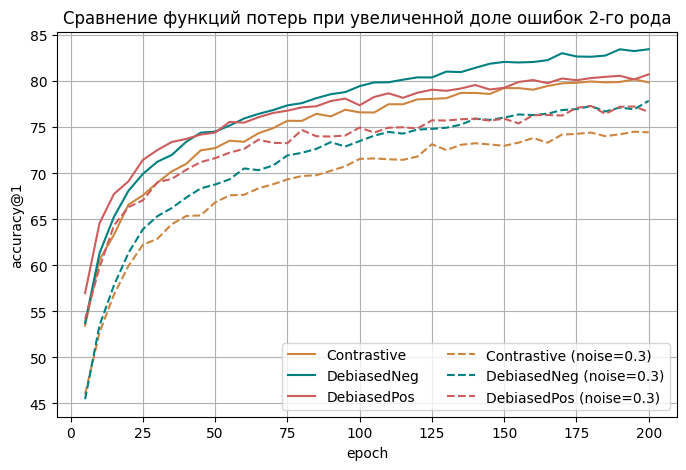

In [17]:
plt.figure(figsize=(8, 5))
for i, row in base_df.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"], color=colors_map[row["loss"]])

for i, row in new_df_3.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(
        m["epoch"], m["loss/acc1"], label=row["loss"] + " (noise=0.3)", color=colors_map[row["loss"]], linestyle="--"
    )

plt.legend(ncol=2)
plt.xlabel("epoch")
plt.ylabel("accuracy@1")
plt.title("Сравнение функций потерь при увеличенной доле ошибок 2-го рода")
plt.grid()
plt.show()

При сильном зашумлении (даже без исключени ошибок 1го рода) debiasedPos и debiasedNeg находятся в паритете. 
При этом на ранних эпохах debiasedPos все еще лучше.

Т.е. исправление ошибки 2го рода с помощью debiasedPos равноценно исправлению ошибки 1го рода с помощью debiasedNeg, если в датасете присутствуют и ошибки 1го, и ошибки 2го рода. (В данном случае доля ошибок 2го роды выше)

In [18]:
def get_last_acc1(df):
    res = []
    for i, row in df.iterrows():
        m = get_metrics(row["uuid"]) 
        m = m[m['epoch'] == m['epoch'].max()]["loss/acc1"]
        res.append(m.values[0])
    return np.array(res)

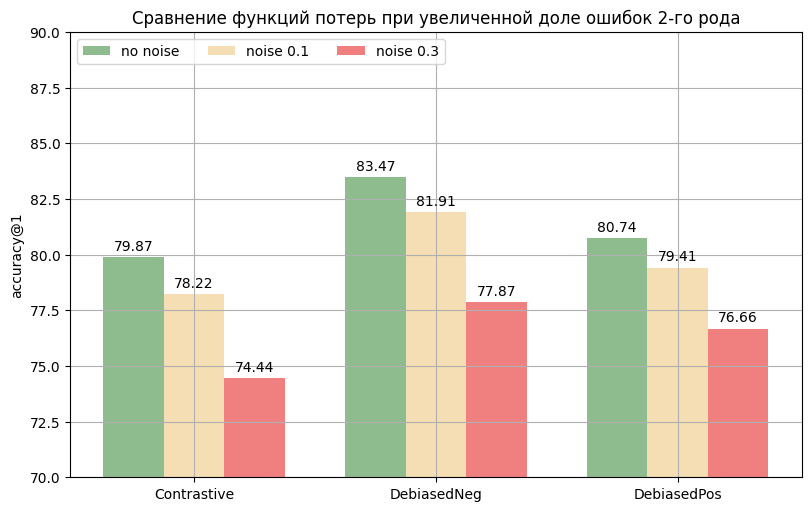

In [19]:
losses = ("Contrastive", "DebiasedNeg", "DebiasedPos")
noise_acc = {
    'no noise': get_last_acc1(base_df),
    'noise 0.1': get_last_acc1(new_df_1),
    'noise 0.3': get_last_acc1(new_df_3),
}

x = np.arange(len(losses))  
width = 0.25 
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 5))

for (attribute, measurement), color in zip(noise_acc.items(), ["darkseagreen", "wheat", "lightcoral"]):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=color)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('accuracy@1')
ax.set_title('Сравнение функций потерь при увеличенной доле ошибок 2-го рода')
ax.set_xticks(x + width, losses)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(70, 90)

plt.grid()

plt.show()

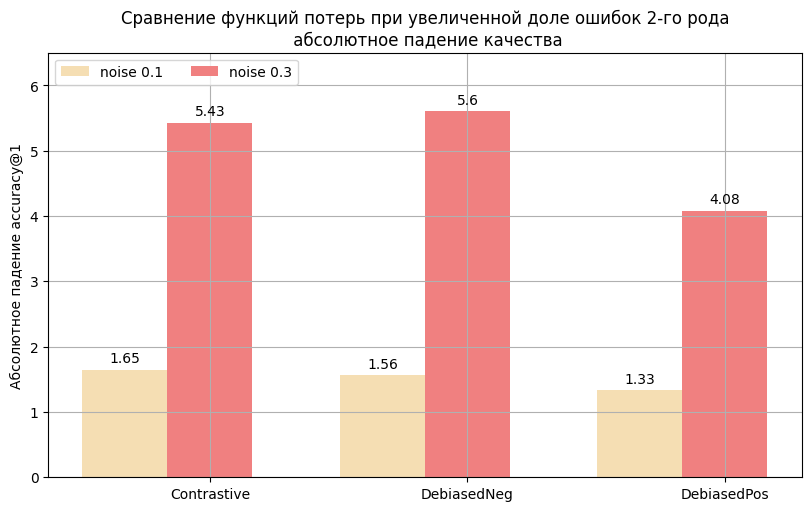

In [20]:
losses = ("Contrastive", "DebiasedNeg", "DebiasedPos")
noise_acc = {
    'noise 0.1': get_last_acc1(base_df) - get_last_acc1(new_df_1),
    'noise 0.3': get_last_acc1(base_df) - get_last_acc1(new_df_3),
}

x = np.arange(len(losses))  
width = 0.33 
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 5))

for (attribute, measurement), color in zip(noise_acc.items(), ["wheat", "lightcoral"]):
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(measurement, 2), width, label=attribute, color=color)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Абсолютное падение accuracy@1')
ax.set_title('Сравнение функций потерь при увеличенной доле ошибок 2-го рода\n абсолютное падение качества')
ax.set_xticks(x + width, losses)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 6.5)

plt.grid()

plt.show()

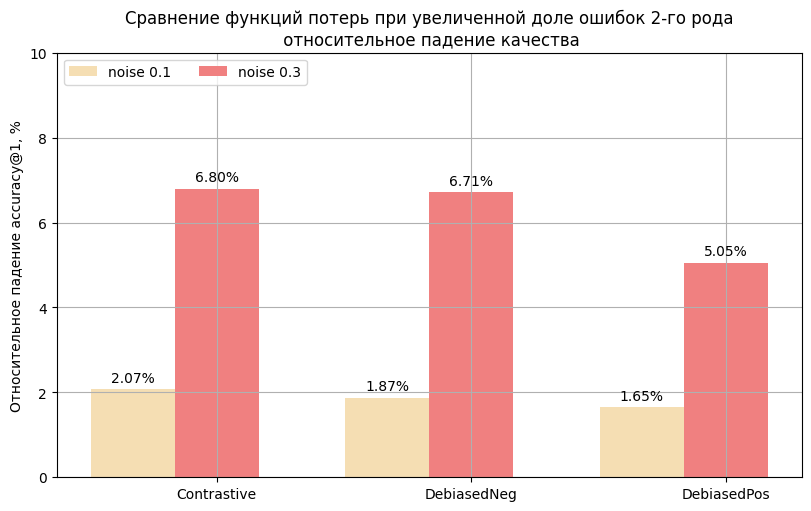

In [21]:
losses = ("Contrastive", "DebiasedNeg", "DebiasedPos")
noise_acc = {
    'noise 0.1': (get_last_acc1(base_df) - get_last_acc1(new_df_1)) / get_last_acc1(base_df),
    'noise 0.3': (get_last_acc1(base_df) - get_last_acc1(new_df_3)) / get_last_acc1(base_df),
}

x = np.arange(len(losses))  
width = 0.33
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 5))

for (attribute, measurement), color in zip(noise_acc.items(), ["wheat", "lightcoral"]):
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(measurement, 4) * 100, width, label=attribute, color=color)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Относительное падение accuracy@1, %')
ax.set_title('Сравнение функций потерь при увеличенной доле ошибок 2-го рода\n относительное падение качества')
ax.set_xticks(x + width, losses)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 10)

for p in ax.containers:
    ax.bar_label(p, fmt='%.2f%%', label_type='edge', padding=3)

plt.grid()

plt.show()

### base VS Nose=True and Drop FN = True

In [22]:
new_dict = base_dict.copy()
new_dict["noise_frac"] = 0.1
new_dict["drop_fn"] = True

x = exp_df.copy()
for k, v in new_dict.items():
    x = x[x[k] == v].copy()
new_df = x.sort_values("loss").copy()
new_df

,k,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,m_agg_mode,noise_frac,feature_dim,temperature
14,200,Contrastive,3e54bb51-d54b-4afa-b97b-6d97d574f300,resnet50,200,CIFAR10,True,1,0.1,64,loss_combination,0.1,128,0.5
15,200,DebiasedNeg,269322aa-b068-4f00-99b1-206e8a2d96bb,resnet50,200,CIFAR10,True,1,0.1,64,loss_combination,0.1,128,0.5
11,200,DebiasedPos,133c2dc1-dc3b-446a-85f0-1cc64542aa5d,resnet50,200,CIFAR10,True,1,0.1,64,loss_combination,0.1,128,0.5


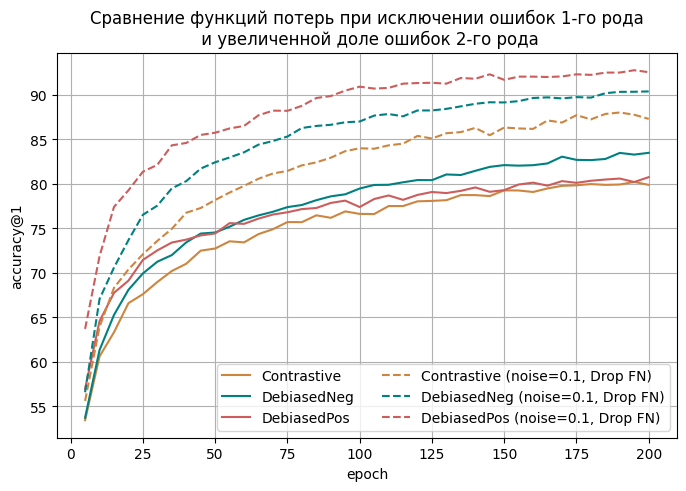

In [23]:
plt.figure(figsize=(8, 5))
for i, row in base_df.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"], color=colors_map[row["loss"]])

for i, row in new_df.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(
        m["epoch"], m["loss/acc1"], label=row["loss"] + " (noise=0.1, Drop FN)", color=colors_map[row["loss"]], linestyle="--"
    )

plt.legend(ncol=2)
plt.xlabel("epoch")
plt.ylabel("accuracy@1")
plt.title("Сравнение функций потерь при исключении ошибок 1-го рода\n и увеличенной доле ошибок 2-го рода")
plt.grid()
plt.show()

Не особо полезный график, просто показывает улучшение. Насколько влияет шум - ниже

### Drop FN = True VS Nose=True and Drop FN = True

In [24]:
new_dict_1 = base_dict.copy()
new_dict_1["drop_fn"] = True

x = exp_df.copy()
for k, v in new_dict_1.items():
    x = x[x[k] == v].copy()
new_dict_1 = x.sort_values("loss").copy()
new_dict_1

,k,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,m_agg_mode,noise_frac,feature_dim,temperature
19,200,Contrastive,7bd9f783-0f8f-446a-aa08-8e011d08eef3,resnet50,200,CIFAR10,True,1,0.1,64,loss_combination,0.0,128,0.5
16,200,DebiasedNeg,d7ca6f2d-627a-4f88-9800-cc36654d3e21,resnet50,200,CIFAR10,True,1,0.1,64,loss_combination,0.0,128,0.5
12,200,DebiasedPos,95906880-716b-4c72-8c79-022baa101109,resnet50,200,CIFAR10,True,1,0.1,64,loss_combination,0.0,128,0.5


In [25]:
new_dict_2 = base_dict.copy()
new_dict_2["noise_frac"] = 0.1
new_dict_2["drop_fn"] = True

x = exp_df.copy()
for k, v in new_dict_2.items():
    x = x[x[k] == v].copy()
new_dict_2 = x.sort_values("loss").copy()
new_dict_2

,k,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,m_agg_mode,noise_frac,feature_dim,temperature
14,200,Contrastive,3e54bb51-d54b-4afa-b97b-6d97d574f300,resnet50,200,CIFAR10,True,1,0.1,64,loss_combination,0.1,128,0.5
15,200,DebiasedNeg,269322aa-b068-4f00-99b1-206e8a2d96bb,resnet50,200,CIFAR10,True,1,0.1,64,loss_combination,0.1,128,0.5
11,200,DebiasedPos,133c2dc1-dc3b-446a-85f0-1cc64542aa5d,resnet50,200,CIFAR10,True,1,0.1,64,loss_combination,0.1,128,0.5


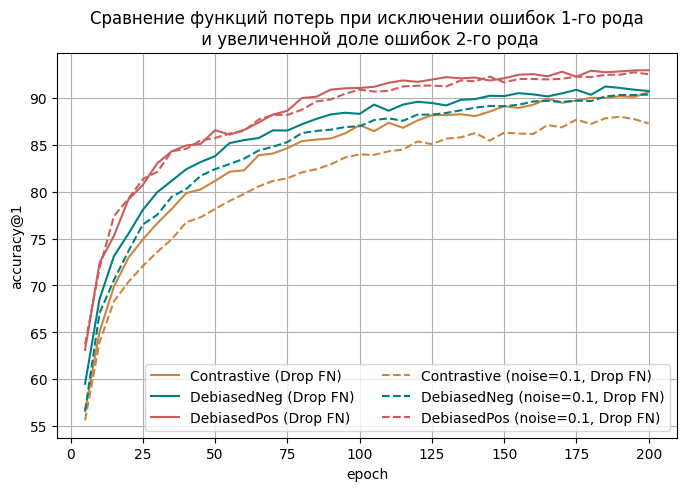

In [26]:
plt.figure(figsize=(8, 5))
for i, row in new_dict_1.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (Drop FN)", color=colors_map[row["loss"]])

for i, row in new_dict_2.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(
        m["epoch"], m["loss/acc1"], label=row["loss"] + " (noise=0.1, Drop FN)", color=colors_map[row["loss"]], linestyle="--"
    )

plt.legend(ncol=2)
plt.xlabel("epoch")
plt.ylabel("accuracy@1")
plt.title("Сравнение функций потерь при исключении ошибок 1-го рода\n и увеличенной доле ошибок 2-го рода")
plt.grid()
plt.show()

Если в датасете отсутствуют ошибки 1го рода и присутствует зашумление ошибками 2го рода, то качество падает незначительно для debiasedPos и debiasedNeg

Для contrastive падение сильное 

## Эксперимент: base VS M=2 (loss_combination)
Сравниваем все лоссы. Хотим убедиться, что увеличение M положительно влияет на качество. Хотим посмотреть, как изменится ранжирование лоссов при новом параметре.

In [27]:
new_dict = base_dict.copy()
new_dict["num_pos"] = 2

x = exp_df.copy()
for k, v in new_dict.items():
    x = x[x[k] == v].copy()
new_df = x.sort_values("loss").copy()
new_df

,k,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,m_agg_mode,noise_frac,feature_dim,temperature
0,200,Contrastive,35116b37-823b-4a1b-b638-0077a8926445,resnet50,200,CIFAR10,False,2,0.1,64,loss_combination,0.0,128,0.5
1,200,DebiasedNeg,41b0aaf1-9456-41dd-b72f-8cfd4ba05a4d,resnet50,200,CIFAR10,False,2,0.1,64,loss_combination,0.0,128,0.5
2,200,DebiasedPos,191f92b9-931a-4f34-b122-6792c5744a65,resnet50,200,CIFAR10,False,2,0.1,64,loss_combination,0.0,128,0.5


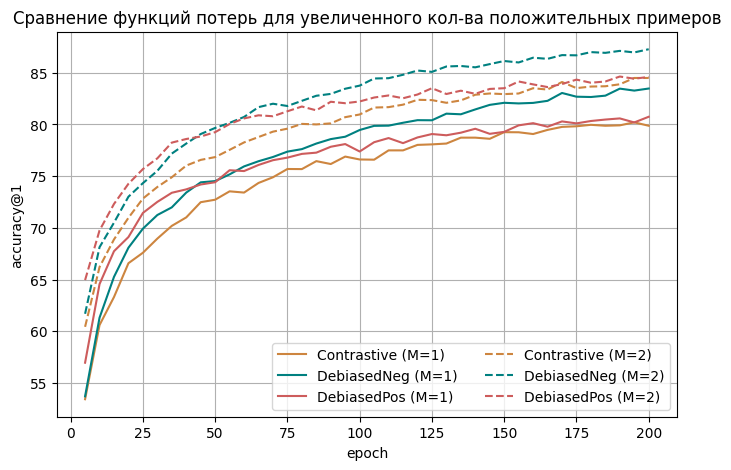

In [28]:
plt.figure(figsize=(8, 5))
for i, row in base_df.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (M=1)", color=colors_map[row["loss"]])

for i, row in new_df.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (M=2)", color=colors_map[row["loss"]], linestyle="--")

plt.legend(ncol=2)
plt.xlabel("epoch")
plt.ylabel("accuracy@1")
plt.title("Сравнение функций потерь для увеличенного кол-ва положительных примеров")
plt.grid()
plt.show()

Увеличение кол-ва положительных примеров улучшает качество. Ранжирование лоссов поменялось: contrastive стал лучше debiasedPos

## Эксперимент: M=2 (loss_combination) VS M=2 (pos_grouping) для DebiasedNeg
Только для DebiasedNeg. Хотим увидеть, какой способ добавления M работает лучше

In [29]:
new_dict = base_dict.copy()
new_dict["num_pos"] = 2
new_dict["m_agg_mode"] = "pos_grouping"
new_dict["loss"] = "DebiasedNeg"

x = exp_df.copy()
for k, v in new_dict.items():
    x = x[x[k] == v].copy()
new_df_1 = x.sort_values("loss").copy()
new_df_1

,k,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,m_agg_mode,noise_frac,feature_dim,temperature
20,200,DebiasedNeg,e73e8c3e-bb87-4845-ade5-19c7fb8f3f82,resnet50,200,CIFAR10,False,2,0.1,64,pos_grouping,0.0,128,0.5


In [30]:
new_dict = base_dict.copy()
new_dict["num_pos"] = 2
new_dict["m_agg_mode"] = "loss_combination"
new_dict["loss"] = "DebiasedNeg"

x = exp_df.copy()
for k, v in new_dict.items():
    x = x[x[k] == v].copy()
new_df_2 = x.sort_values("loss").copy()
new_df_2

,k,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,m_agg_mode,noise_frac,feature_dim,temperature
1,200,DebiasedNeg,41b0aaf1-9456-41dd-b72f-8cfd4ba05a4d,resnet50,200,CIFAR10,False,2,0.1,64,loss_combination,0.0,128,0.5


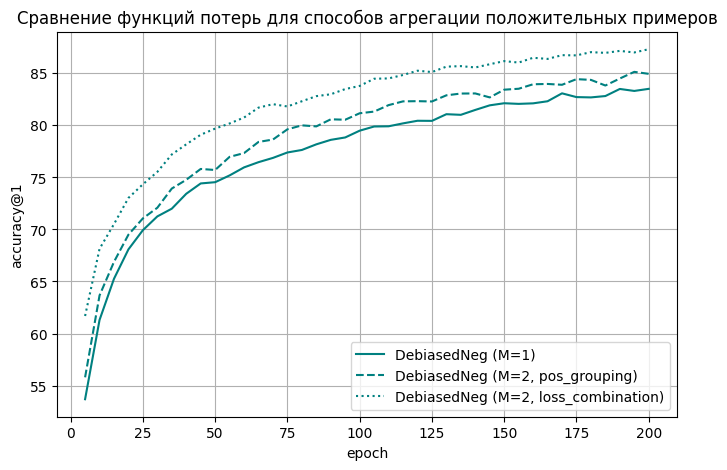

In [31]:
plt.figure(figsize=(8, 5))
for i, row in base_df[base_df['loss'] == 'DebiasedNeg'].iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (M=1)", color=colors_map[row["loss"]])

for i, row in new_df_1.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (M=2, pos_grouping)", color=colors_map[row["loss"]], linestyle="--")

for i, row in new_df_2.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (M=2, loss_combination)", color=colors_map[row["loss"]], linestyle=":")

plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy@1")
plt.title("Сравнение функций потерь для способов агрегации положительных примеров")
plt.grid()
plt.show()

Агрегация лоссов лучше бустит качество, чем предлагаемый в статье способ

## Эксперимент: base VS bs=256
Сравниваем все лоссы. Ожидаем, что при большем bs метрики лучше. Хотим посмотреть, как изменится ранжирование лоссов при новом параметре.

In [32]:
new_dict = base_dict.copy()
new_dict["batch_size"] = 256

x = exp_df.copy()
for k, v in new_dict.items():
    x = x[x[k] == v].copy()
new_df = x.sort_values("loss").copy()
new_df

,k,loss,uuid,model,epochs,dataset,drop_fn,num_pos,tau_plus,batch_size,m_agg_mode,noise_frac,feature_dim,temperature
6,200,Contrastive,82eefce6-cbf5-4d9e-b410-46ea27bb572f,resnet50,200,CIFAR10,False,1,0.1,256,loss_combination,0.0,128,0.5
7,200,DebiasedNeg,e0c2f57e-bf0c-40d0-b6aa-cf0c752fc55d,resnet50,200,CIFAR10,False,1,0.1,256,loss_combination,0.0,128,0.5
8,200,DebiasedPos,9572d8e9-6496-4ef3-a85c-08525d56eae6,resnet50,200,CIFAR10,False,1,0.1,256,loss_combination,0.0,128,0.5


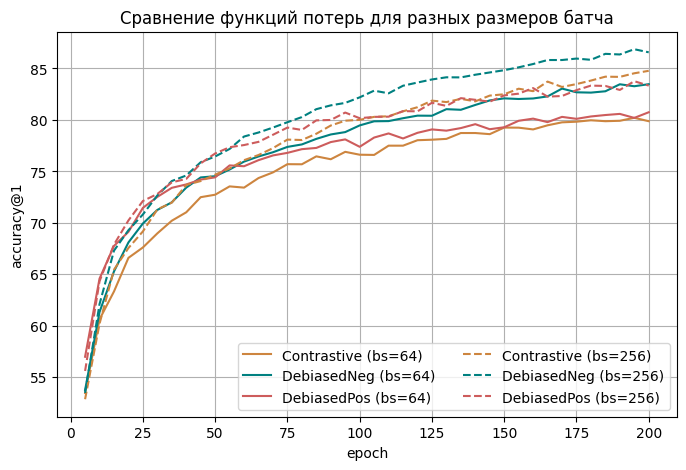

In [33]:
plt.figure(figsize=(8, 5))
for i, row in base_df.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (bs=64)", color=colors_map[row["loss"]])

for i, row in new_df.iterrows():
    m = get_metrics(row["uuid"])
    plt.plot(m["epoch"], m["loss/acc1"], label=row["loss"] + " (bs=256)", color=colors_map[row["loss"]], linestyle="--")

plt.legend(ncol=2)
plt.xlabel("epoch")
plt.ylabel("accuracy@1")
plt.title("Сравнение функций потерь для разных размеров батча")
plt.grid()
plt.show()

Увеличение размера батча очевидно улучшает качество. Ранжирование лоссов в базовом эксперименте при этом не меняется